In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, UpSampling2D, ZeroPadding2D, concatenate, Input, MaxPooling2D, Flatten, Dense, Dropout, Activation, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import albumentations as A
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.optimizers import Adam
import os

2024-06-30 11:54:00.053958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 11:54:00.067199: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 11:54:00.067216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-30 11:54:00.075354: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO:matplotlib.font_manager:generated new fontManag

In [2]:
class Config:
    batch_size = 16                             # Размер батча
    image_width = 320                           # целевая ширина картинки
    image_height = 320                          # целевая высота картинки
    image_channels = 3                          # кол-во входных каналов
    image_size = (image_width, image_height)    # 
    test_split = 0.2                            # доля тестовых данных
    val_split = 0.0                             # доля валидационных данных
    epochs = 1000                               # кол-во эпох обучения
    lr = 1e-3
    scheduler_alpha = lr / 10
    smart_resize = True
    

# Подготовка данных 


In [3]:
def preprocess_input(x):
    """
    Препроцессинг для VGG16 - imagenet
    """
    
    if x.dtype == np.uint8:
        x = x / 1.0

    mean = [103.939, 116.779, 123.68]
    x[..., 0] -= mean[0]
    x[..., 1] -= mean[1]
    x[..., 2] -= mean[2]
    return x

def deprocess_input(x):
    x[..., 0] += 103.939
    x[..., 1] += 116.779
    x[..., 2] += 123.68
    return x.astype(np.uint8)

def resize(img, out_shape):
    """
    Умный ресайз, не сплющивает/растягивает картинку, но добавляются черные полосы
    """
    h, w, channels = img.shape
    output_h , output_w = out_shape
    max_size = max(h, w)
    square_image = np.zeros((max_size, max_size, channels))
    x_offset = (max_size - w) // 2
    y_offset = (max_size - h) // 2
    square_image[y_offset : y_offset + h, x_offset : x_offset + w] = img
    square_image = cv2.resize(square_image, (output_h, output_w))
    return square_image


In [4]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_dir, mask_dir, batch_size=32, image_size=(480, 640), 
                 augmentation=None, test_split=0.2, val_split=0.2, mode='train', **kwargs):
        super().__init__(**kwargs)
        """
        Инициализация генератора данных

        Parameters:
        - image_dir: Папка с изображениями.
        - mask_dir: Папка с масками.
        - batch_size: Размер батча.
        - image_size: Целевой размер изображений.
        - augmentation: Пайплайн аугментации.
        - test_split: Процент данных для тестовой выборки.
        - mode: Режим работы генератора ('train' или 'test' или 'val').
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.augmentation = augmentation
        self.mode = mode

        self.image_ids = os.listdir(image_dir)
        self.image_ids.sort() 

        total_size = len(self.image_ids)
        test_size = int(total_size * test_split)
        val_size = int(total_size * val_split)

        if self.mode == 'train':
            self.data_ids = self.image_ids[:-(test_size + val_size)]
        elif self.mode == 'val':
            self.data_ids = self.image_ids[-(test_size + val_size):-test_size]
        elif self.mode == 'test':
            self.data_ids = self.image_ids[-test_size:]
        else:
            raise ValueError("Invalid mode. Choose from 'train' or 'test' or 'val'")

        assert 1 - val_split - test_split > 0 
        
    def __len__(self):
        """Возвращает количество шагов за эпоху"""
        return int(np.floor(len(self.data_ids) / self.batch_size))

    def __getitem__(self, index):
        """Возвращает пакет данных"""
        batch_ids = self.data_ids[index*self.batch_size:(index+1)*self.batch_size]
        images, masks, labels = self.__data_generation(batch_ids)
        return images, (masks, labels) 

    def __data_generation(self, batch_ids):
        """Генерирует данные для пакета"""
        images = []
        masks = []
        labels = []

        for id in batch_ids:
            image_path = os.path.join(self.image_dir, id)
            mask_path = os.path.join(self.mask_dir, id).replace('.jpg', '.png')
            
            image = cv2.imread(image_path)
            image = preprocess_input(image)
            

            mask = cv2.imread(mask_path)
            mask = mask / 255.0
            mask = mask[:, :, :1]
            
            if self.augmentation:
                augmented = self.augmentation(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            if np.max(mask) > 0:
                labels.append(1)
            else:
                labels.append(0)
            
            if Config.smart_resize:
                image = resize(image,  self.image_size)
                mask = resize(mask, self.image_size)
            else:
                image = cv2.resize(image, self.image_size)
                mask = cv2.resize(mask, self.image_size)
            
            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks), np.array(labels) 


In [5]:
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=35, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RandomScale(scale_limit=0.1, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.2)

])

image_dir = 'dataset/images'
mask_dir = 'dataset/masks'

train_gen = DataGenerator(
    image_dir=image_dir,
    mask_dir=mask_dir,
    batch_size=Config.batch_size,
    image_size=Config.image_size,
    augmentation=augmentation, 
    test_split=Config.test_split,
    val_split=Config.val_split,
    mode='train'
)


test_gen = DataGenerator(
    image_dir=image_dir,
    mask_dir=mask_dir,
    batch_size=Config.batch_size,
    image_size=Config.image_size,
    augmentation=None,  
    test_split=Config.test_split,
    val_split=Config.val_split,
    mode='test'
)

val_gen = DataGenerator(
    image_dir=image_dir,
    mask_dir=mask_dir,
    batch_size=Config.batch_size,
    image_size=Config.image_size,
    augmentation=augmentation,  
    test_split=Config.test_split,
    val_split=Config.val_split,
    mode='val'
)



# Модель
В качестве энкодера была выбрана архитектура VGG16 с предобученными на imagenet весами 


In [6]:
def get_vgg_encoder(input_height=224,  input_width=224, channels=3):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    
    img_input = Input(shape=(input_height, input_width, channels))

    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv1', kernel_regularizer=l2(0.001))(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same',
               name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same',
               name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv1', kernel_regularizer=l2(0.01))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same',
               name='block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same',
               name='block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
    f5 = x

    pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                     "releases/download/v0.1/" \
                     "vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"
    
    VGG_Weights_path = tf.keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
    
    Model(img_input, x).load_weights(VGG_Weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

In [7]:
def _unet(n_classes, encoder, l1_skip_conn=True, input_height=416,
          input_width=608, channels=3):

    img_input, levels = encoder(
        input_height=input_height, input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    # upsampling block 5
    o = f5
    # o = ZeroPadding2D((1, 1))(o)
    o = Conv2DTranspose(512, (3, 3), strides = (2,2), padding='same')(o)
    # o = Conv2D(512, (3, 3), padding='valid')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    # o = UpSampling2D((2, 2))(o)

    # upsampling block 4
    o = concatenate([o, f4], axis=-1)
    # o = ZeroPadding2D((1, 1))(o)
    o = Conv2DTranspose(512, (3, 3), strides = (2,2), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    # o = UpSampling2D((2, 2))(o)

    # upsampling block 3
    o = concatenate([o, f3], axis=-1)
    # o = ZeroPadding2D((1, 1))(o)
    o = Conv2DTranspose(256, (3, 3), strides = (2,2), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    # o = UpSampling2D((2, 2))(o)

    # upsampling block 2
    o = concatenate([o, f2], axis=-1)
    # o = ZeroPadding2D((1, 1))(o)
    # o = Conv2D(128, (3, 3), padding='valid')(o)
    o = Conv2DTranspose(128, (3, 3), strides = (2,2), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)
    # o = UpSampling2D((2, 2))(o)

    # upsampling block 1
    if l1_skip_conn:
        o = (concatenate([o, f1], axis=-1))

    # o = ZeroPadding2D((1, 1))(o)
    # o = Conv2D(64, (3, 3), padding='valid',  name="seg_feats")(o)
    o = Conv2DTranspose(64, (3, 3), strides = (2,2), padding='same')(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o = Conv2D(n_classes, (1, 1), padding='same', activation="sigmoid", name = 'mask')(o)

    
    # o = UpSampling2D((2, 2), name = 'mask')(o)


    # Цепляемся к энкодеру нашей сети и строим дополнительную полносвязную голову - классификатор
    classifier = Flatten()(f5)
    classifier = Dense(4096, kernel_regularizer=l2(0.01))(classifier)
    classifier = BatchNormalization()(classifier)
    classifier = Activation('relu')(classifier)
    classifier = Dropout(0.5)(classifier)

    classifier = Dense(4096, kernel_regularizer=l2(0.01))(classifier)
    classifier = BatchNormalization()(classifier)
    classifier = Activation('relu')(classifier)
    classifier = Dropout(0.5)(classifier)

    classifier = Dense(1, activation="sigmoid", name = 'label')(classifier)
    

    model = Model(img_input, [o, classifier])

    return model

In [8]:
def vgg_unet(n_classes, input_height=480, input_width=640, channels=3):

    model = _unet(n_classes, get_vgg_encoder,
                  input_height=input_height, input_width=input_width, channels=channels)
    
    for layer in model.layers:
        if 'block' in layer.name:
            layer.trainable = False
            
    model.model_name = "vgg_unet"
    return model

In [9]:
model = vgg_unet(n_classes = 1, input_height=Config.image_height, input_width=Config.image_width, channels=Config.image_channels)

2024-06-30 11:54:02.738879: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 11:54:02.748599: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 11:54:02.748810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Обучение модели

In [10]:
# функция ошибки для сегментатора 

def dice_coef(y_true, y_pred, smooth=1):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)


In [11]:
# настраиваем оптимизатор

decay_steps = len(train_gen) * Config.epochs
scheduler = CosineDecay(Config.lr, decay_steps, Config.scheduler_alpha)
optimizer = Adam(learning_rate=scheduler)

In [12]:

model.compile(
    optimizer=optimizer,
    loss = [dice_loss, 'binary_crossentropy'],
    metrics={
        'mask': [dice_coef],  
        'label': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]   
    },
    loss_weights = [0.6, 0.4]
)


In [13]:
if Config.val_split > 0:
    monitor = 'val_loss'
else:
    monitor = 'loss'

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.keras',   
    monitor=monitor,   
    save_best_only=True,               
    mode='min',                        
    verbose=1                          
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor=monitor,      
    patience=250,                       
    restore_best_weights=True,         
    mode='min',                        
    verbose=1                          
)



In [14]:
if Config.val_split > 0:
    history = model.fit(train_gen,  validation_data=val_gen, epochs=Config.epochs, callbacks=[early_stopping, checkpoint])
else:
    history = model.fit(train_gen, epochs=Config.epochs, callbacks=[early_stopping, checkpoint])

Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - label_accuracy: 0.9328 - label_precision: 0.9839 - label_recall: 0.8713 - loss: 0.3662 - mask_dice_coef: 0.7030
Epoch 925: loss did not improve from 0.28059
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - label_accuracy: 0.9321 - label_precision: 0.9841 - label_recall: 0.8702 - loss: 0.3666 - mask_dice_coef: 0.7028
Epoch 926/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - label_accuracy: 0.9446 - label_precision: 0.9914 - label_recall: 0.8928 - loss: 0.3071 - mask_dice_coef: 0.7657
Epoch 926: loss did not improve from 0.28059
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - label_accuracy: 0.9457 - label_precision: 0.9886 - label_recall: 0.8979 - loss: 0.3074 - mask_dice_coef: 0.7654
Epoch 927/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - label_accuracy: 0.9411 - label_precision: 0.9302 - label_recall: 0.9635 - loss: 0.3307 - mask_dice_coef: 0.7526
Epoch 927: loss did not improve from 0.28059
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - labe

I0000 00:00:1719748448.937339   14958 service.cc:145] XLA service 0x7fca7c023a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719748448.937365   14958 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-06-30 11:54:09.057414: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-30 11:54:09.488257: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


 1/10 ━━━━━━━━━━━━━━━━━━━━ 2:52 19s/step - label_accuracy: 0.3750 - label_precision: 0.5000 - label_recall: 0.2000 - loss: 117.7803 - mask_dice_coef: 0.1426

I0000 00:00:1719748462.798929   14958 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_53', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1719748462.807028   14958 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - label_accuracy: 0.5103 - label_precision: 0.5636 - label_recall: 0.5029 - loss: 96.2054 - mask_dice_coef: 0.1470
Epoch 1: loss improved from inf to 81.18794, saving model to model_checkpoint.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 3s/step - label_accuracy: 0.5173 - label_precision: 0.5645 - label_recall: 0.5119 - loss: 94.8401 - mask_dice_coef: 0.1462  
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - label_accuracy: 0.7090 - label_precision: 0.6912 - label_recall: 0.7217 - loss: 53.7742 - mask_dice_coef: 0.1438
Epoch 2: loss improved from 81.18794 to 50.23373, saving model to model_checkpoint.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - label_accuracy: 0.7081 - label_precision: 0.6909 - label_recall: 0.7202 - loss: 53.4523 - mask_dice_coef: 0.1444  
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - label_accuracy: 0.7866 - label_precision: 0.8310 - label_recall: 0.6964 - loss: 37.8526 - mask_dice_coef: 0.1748
Epoch 3: loss improve

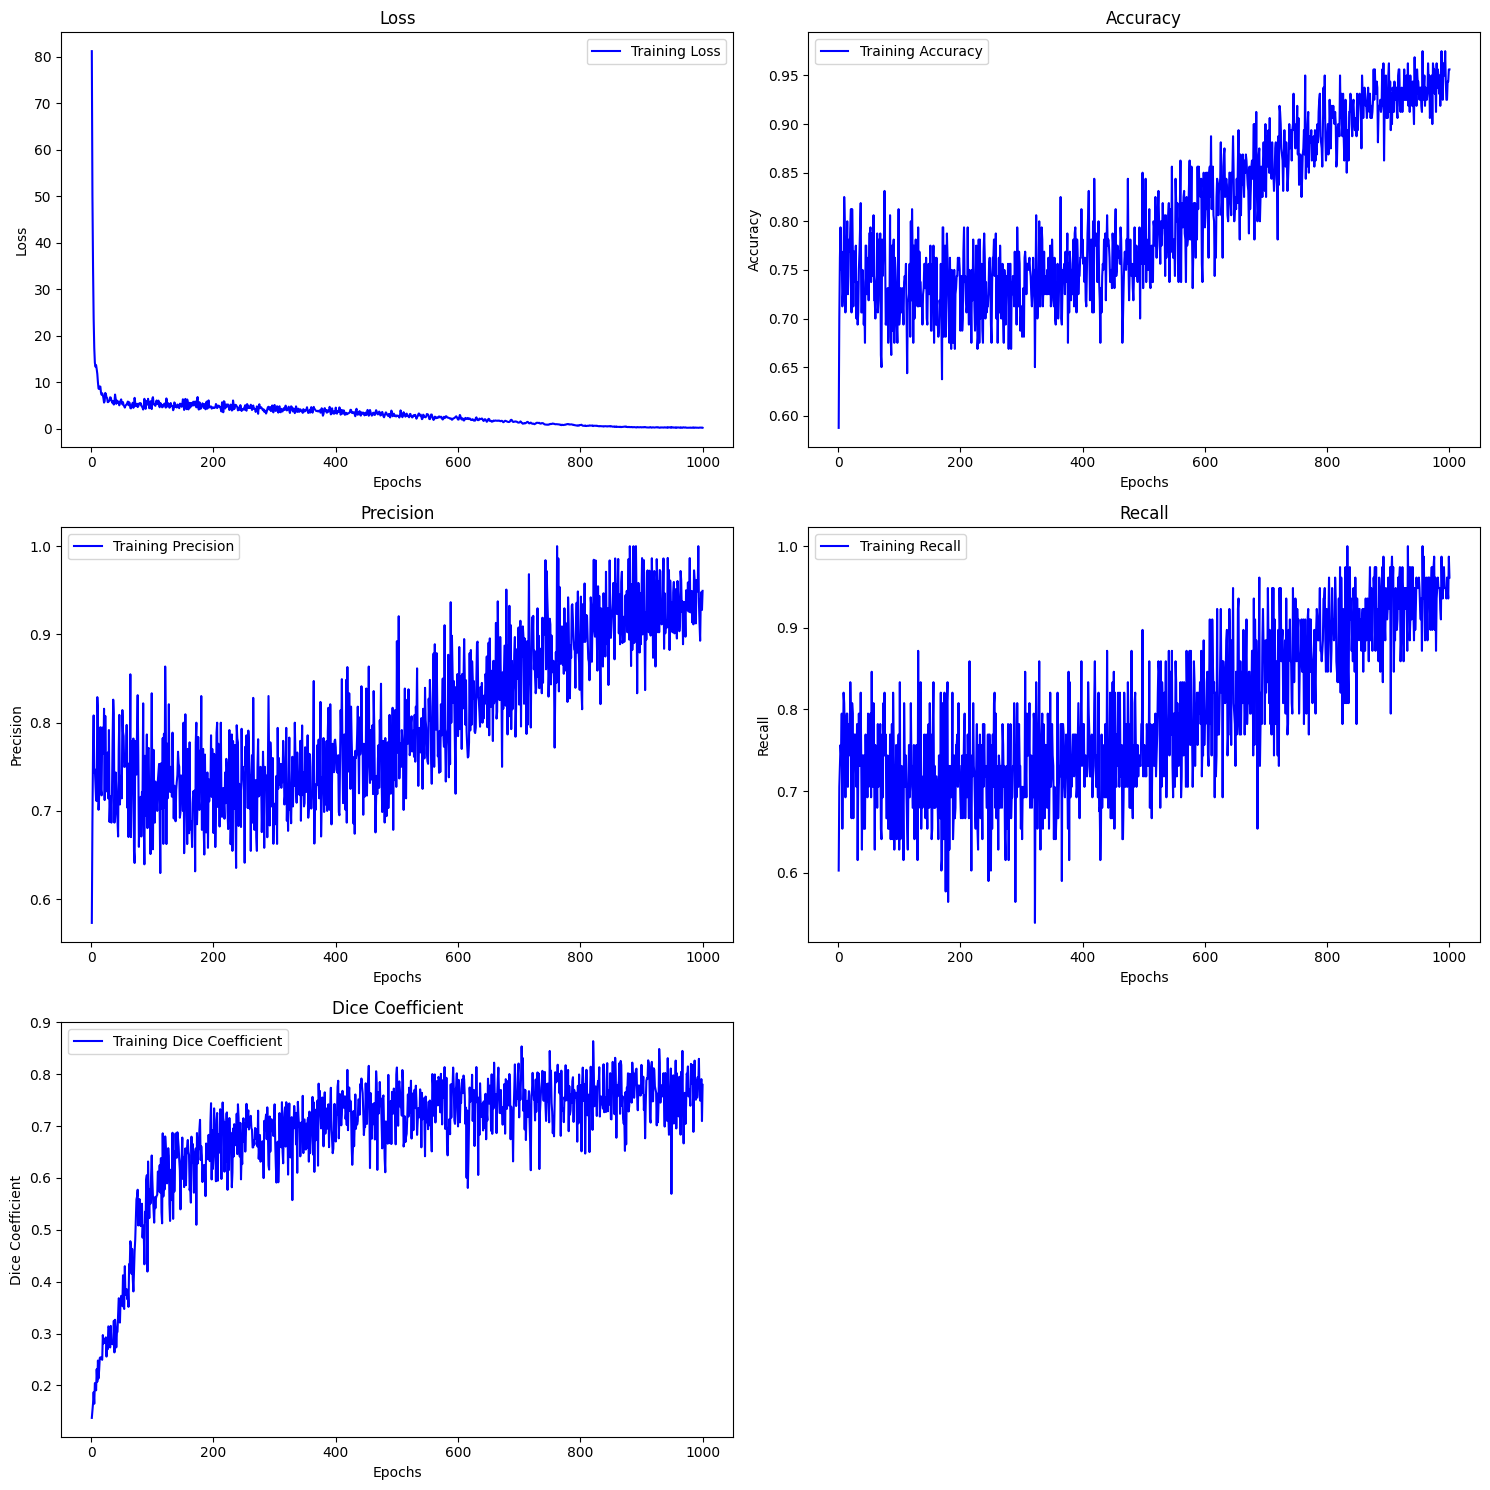

In [15]:
def plot_training_history(history):
    """
    Функция для визуализации метрик и потерь из истории обучения модели.
    
    Parameters:
    - history: объект History, возвращаемый методом model.fit
    """
    metrics = history.history
    epochs = range(1, len(metrics['loss']) + 1)

    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    
    # График потерь
    axs[0, 0].plot(epochs, metrics['loss'], 'b', label='Training Loss')
    if Config.val_split:
        axs[0, 0].plot(epochs, metrics['val_loss'], 'r', label='Validation Loss')
    axs[0, 0].set_title('Loss')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()

    # График accuracy
    axs[0, 1].plot(epochs, metrics['label_accuracy'], 'b', label='Training Accuracy')
    if Config.val_split:
        axs[0, 1].plot(epochs, metrics['val_label_accuracy'], 'r', label='Validation Accuracy')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()
    
    # График precision
    axs[1, 0].plot(epochs, metrics['label_precision'], 'b', label='Training Precision')
    if Config.val_split:
        axs[1, 0].plot(epochs, metrics['val_label_precision'], 'r', label='Validation Precision')
    axs[1, 0].set_title('Precision')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].legend()
    
    # График recall
    axs[1, 1].plot(epochs, metrics['label_recall'], 'b', label='Training Recall')
    if Config.val_split:
        axs[1, 1].plot(epochs, metrics['val_label_recall'], 'r', label='Validation Recall')
    axs[1, 1].set_title('Recall')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Recall')
    axs[1, 1].legend()

    # График dice_coef
    axs[2, 0].plot(epochs, metrics['mask_dice_coef'], 'b', label='Training Dice Coefficient')
    if Config.val_split:
        axs[2, 0].plot(epochs, metrics['val_mask_dice_coef'], 'r', label='Validation Dice Coefficient')
    axs[2, 0].set_title('Dice Coefficient')
    axs[2, 0].set_xlabel('Epochs')
    axs[2, 0].set_ylabel('Dice Coefficient')
    axs[2, 0].legend()

    # Удаление пустого подграфика, если он есть
    axs[2, 1].axis('off')
    
    # Вывод графиков
    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

# Тестирование

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('model_checkpoint.keras', custom_objects={'dice_loss': dice_loss, 'dice_coef': dice_coef})

In [16]:
def predict_image(img):
    """
    Функция для запуска модели на изображении 

    Parameters:
    - img: Входное изображение

    Returns:
    - mask: Результат сегментации
    - p: Результат классификации
    """
    
    img = preprocess_input(img)
    if Config.smart_resize:
        img = resize(img, Config.image_size)
    else:
        img = cv2.resize(img, Config.image_size)
    img = np.expand_dims(img, axis=0)

    mask, p = model.predict(img)
    p = np.round(p[0])
    mask = mask[0]
    return mask, p

In [17]:
def plot_predict_image_and_mask(img):
    mask, p = predict_image(img)
    fig = plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    print("Объект есть" if p > 0.5 else 'Объекта нет')

### прогоняем модель на картинке, где есть объект 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Объект есть


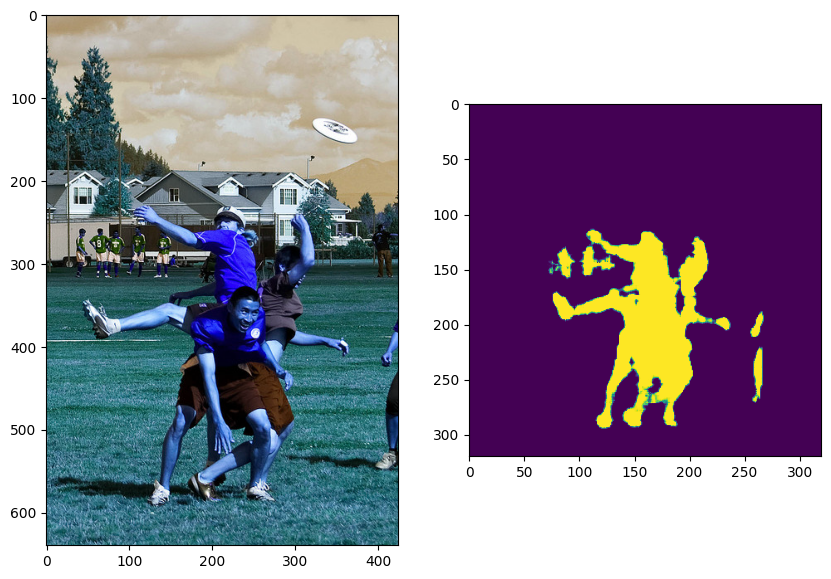

In [18]:
img_with_object = cv2.imread('dataset/images/000000002907.jpg')
plot_predict_image_and_mask(img_with_object)

### прогоняем модель на картинке, где объекта нет

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Объекта нет


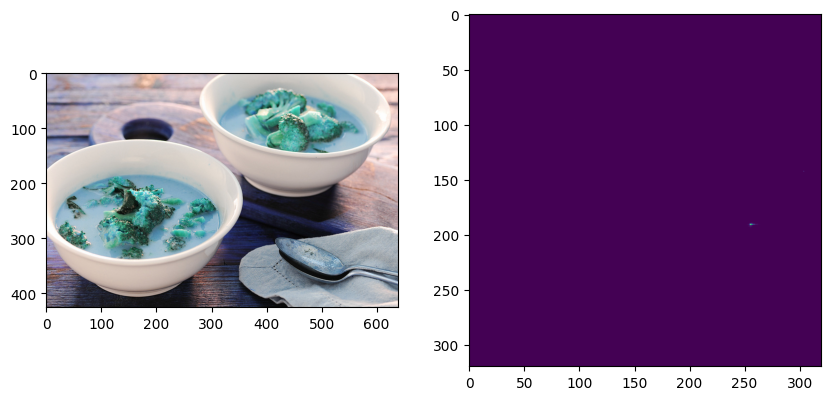

In [19]:
img_without_object = cv2.imread('dataset/images/000000002759.jpg')
plot_predict_image_and_mask(img_without_object)

### Оцениваем качество модели на наших данных

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - label_accuracy: 0.7917 - label_precision: 0.8263 - label_recall: 0.7639 - loss: 0.5884 - mask_dice_coef: 0.6708
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 198ms/step - label_accuracy: 0.9280 - label_precision: 0.9628 - label_recall: 0.8821 - loss: 0.2746 - mask_dice_coef: 0.7672


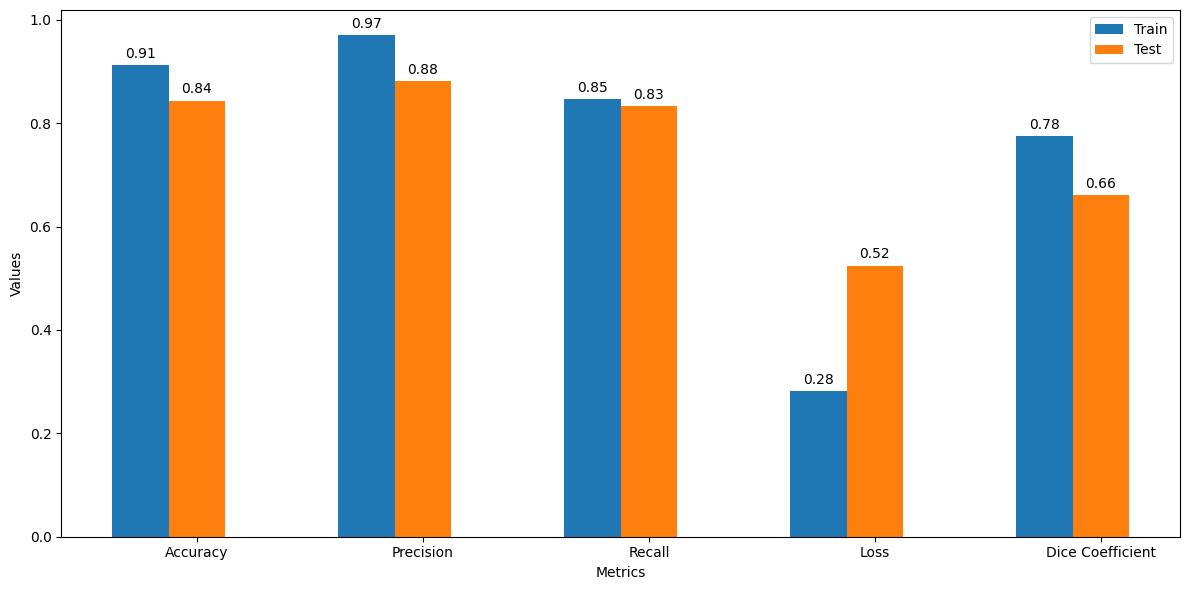

In [23]:
test_loss, test_acc, test_precision, test_recall, test_dice_coef = model.evaluate(test_gen)
train_loss, train_acc, train_precision, train_recall,  train_dice_coef = model.evaluate(train_gen)


metrics = ['Accuracy', 'Precision', 'Recall', 'Loss', 'Dice Coefficient']
test_values = [test_acc, test_precision, test_recall, test_loss, test_dice_coef]
train_values = [train_acc, train_precision, train_recall, train_loss, train_dice_coef]
if Config.val_split > 0:
    val_loss, val_acc , val_precision, val_recall, val_dice_coef = model.evaluate(val_gen)
    val_values = [val_acc, val_precision, val_recall, val_loss, val_dice_coef]

bar_width = 0.25 
index = np.arange(len(metrics)) 

fig, ax = plt.subplots(figsize=(12, 6))

bars1 = ax.bar(index - bar_width, train_values, bar_width, label='Train')
bars2 = ax.bar(index , test_values, bar_width, label='Test')

if Config.val_split > 0:
    bars3 = ax.bar(index+ bar_width, val_values, bar_width, label='Validation')

ax.set_xlabel('Metrics')
ax.set_ylabel('Values')
ax.set_xticks(index)
ax.set_xticklabels(metrics)
ax.legend()

if Config.val_split > 0:
    plot_bars = [bars1, bars2, bars3]
else:
    plot_bars = [bars1, bars2]

for bars in plot_bars:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')


plt.tight_layout()
plt.show()

# прогон тестовых данных через модель

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


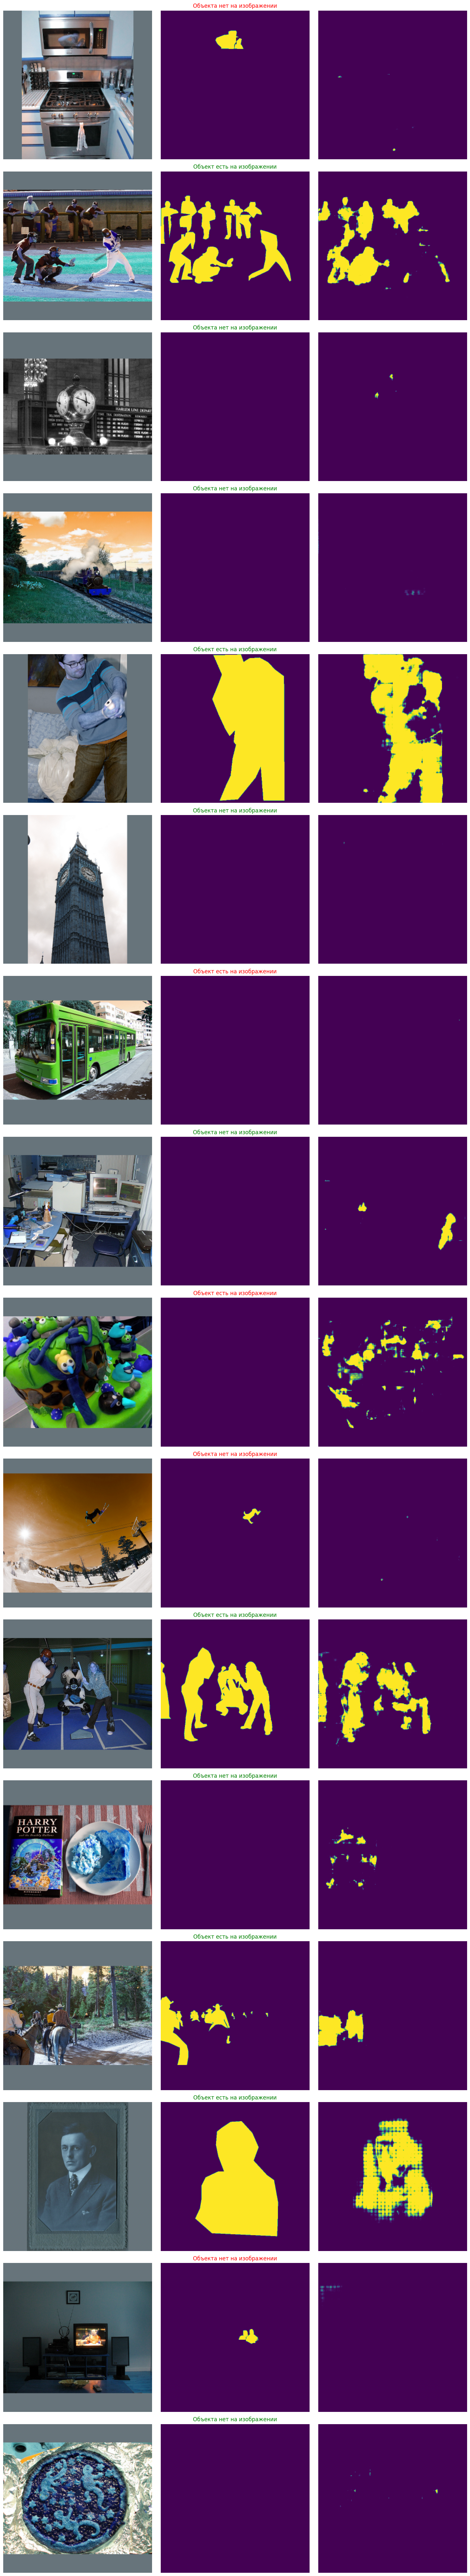

In [24]:
def plot_images_and_masks(imgages, masks, labels, pred_labels, pred_masks, num_pairs_per_row=1):
    num_images = imgages.shape[0]
    num_rows = int(np.ceil(num_images / num_pairs_per_row))

    fig, axs = plt.subplots(num_rows, num_pairs_per_row * 3, figsize=(15, 5 * num_rows))

    for i in range(num_images):
        row = i // num_pairs_per_row
        col = (i % num_pairs_per_row) * 2
        
        if labels[i] == pred_labels[i]:
            color = 'g'  
        else:
            color = 'r'  
        
        title = 'Объект есть на изображении' if pred_labels[i] == 1 else 'Объекта нет на изображении'
        
        axs[row, col].imshow(deprocess_input(imgages[i]))
        axs[row, col].axis('off') 
        
        axs[row, col + 1].imshow(masks[i])
        axs[row, col + 1].set_title(title, color=color)
        axs[row, col + 1].axis('off')  
        
        axs[row, col + 2].imshow(pred_masks[i])
        axs[row, col + 2].axis('off') 

    for j in range(num_images * 2, num_rows * num_pairs_per_row * 2):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()

for imgages, masks_labels in test_gen:
    if len(masks_labels[1]) == 0:
        break

    predict = model.predict(imgages)
    pred_masks, pred_labels = predict
    masks, labels = masks_labels
    
    pred_labels = np.round(pred_labels)  

    plot_images_and_masks(imgages, masks, labels, pred_labels, pred_masks)
    
    break


### Матрица ошибок на тестовых данных

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


I0000 00:00:1719762291.399287   37322 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_434', 28 bytes spill stores, 28 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


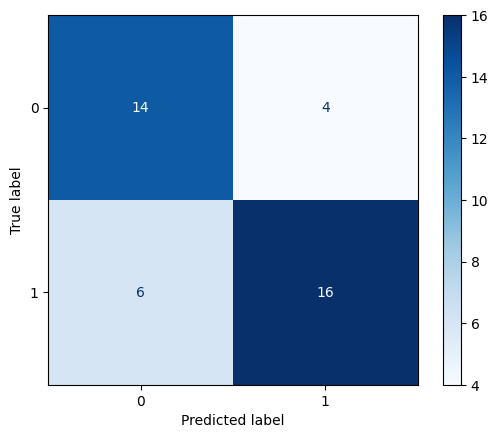

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels = []
pred_labels = []

for imgages, masks_labels in test_gen:
    if len(imgages) == 0:
        break
    masks, labels = masks_labels
    predictions = model.predict(imgages)
    _, predicted_labels = predictions
    
    true_labels.extend(labels)
    pred_labels.extend(np.round(predicted_labels))  

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

cm = confusion_matrix(true_labels, pred_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()